## [LossFunction](https://pytorch.org/docs/stable/nn.html#loss-functions)
计算实际输出与目标之间的差距
为更新输出提供一定的依据（反向传播）
### CrossEntropyLoss()

In [1]:
import torchvision.datasets
from torch import nn
import torch
"""
Example of target with class indices
"""
loss=nn.CrossEntropyLoss()
input=torch.randn(3,5,requires_grad=True)
target=torch.empty(3,dtype=torch.long).random_(5)
output=loss(input,target)
output.backward()

In [2]:
"""
Example of target with class probabilities
"""
input=torch.randn(3,5,requires_grad=True)
target=torch.randn(3,5).softmax(dim=1)
output=loss(input,target)
output.backward()

## (optim)[https://pytorch.org/docs/stable/optim.html]
`torch.optim` is a package implementing various optimization algorithms. Most commonly used methods are already supported, and the interface is general enough, so that more sophisticated ones can be also easily integrated in the future.

In [ ]:
from torch import optim

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam([var1, var2], lr=0.0001)

# for input, target in dataset:
#     optimizer.zero_grad()  # 将loss.backward得到的梯度清零
#     output = model(input)  # 计算y_hat
#     loss = loss_fn(output, target)  # 计算损失
#     loss.backward()  # 将损失反向传播（计算每个参数的梯度）
#     optimizer.step()  # 将参数根据梯度调整

## 训练

### 1.创建dataset和dataloader

In [3]:
import torchvision

data_dir='/media/zhang/Disk0/dataset/d2l/data'

train_data=torchvision.datasets.CIFAR10(
    root=data_dir,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False
)


test_data=torchvision.datasets.CIFAR10(
    root=data_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False
)

train_data_size=len(train_data)  # 查看训练集样本个数
test_data_size=len(test_data)
train_data_size,test_data_size

(50000, 10000)

In [4]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(
    dataset=train_data,
    batch_size=128,
    shuffle=True,
    num_workers=8
)

test_dataloader=DataLoader(
    dataset=test_data,
    batch_size=128,
    shuffle=True,
    num_workers=8
)

### 2.创建模型并验证

In [5]:

import torch
from torch import nn

model = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5,padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=1024,out_features=64),
            nn.Linear(in_features=64,out_features=10)
        )

# 对模型的输出进行验证
# 图片大小为32*32，3个通道，batchsize=128
X=torch.rand(size=(128,3,32,32),dtype=torch.float32)
for layer in model:
    X=layer(X)
    print(layer.__class__.__name__,'output  shape: \t',X.shape)

Conv2d output  shape: 	 torch.Size([128, 32, 32, 32])
MaxPool2d output  shape: 	 torch.Size([128, 32, 16, 16])
Conv2d output  shape: 	 torch.Size([128, 32, 16, 16])
MaxPool2d output  shape: 	 torch.Size([128, 32, 8, 8])
Conv2d output  shape: 	 torch.Size([128, 64, 8, 8])
MaxPool2d output  shape: 	 torch.Size([128, 64, 4, 4])
Flatten output  shape: 	 torch.Size([128, 1024])
Linear output  shape: 	 torch.Size([128, 64])
Linear output  shape: 	 torch.Size([128, 10])


### 3.定义损失函数

In [6]:
loss_fn=nn.CrossEntropyLoss()

### 4.定义优化器

In [16]:
# 1e-2=1 X (10)^(-2)=0.01
lr=1e-2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)

### 5.训练

In [26]:
from torch.utils.tensorboard import SummaryWriter

"""
添加tensorboard
"""
writer=SummaryWriter('./runsLog/logs_train')

In [27]:
total_train_step=0  # 记录训练的次数
total_test_step=0  # 记录测试的次数

epoch=10  # 训练的轮数

for i in range(epoch):
    print(f'---------第',i+1,'轮训练开始---------')

    # 训练开始
    model.train()  # 将模型设置为训练模式

    for data in train_dataloader:
        imgs,tag=data
        outputs=model(imgs)
        loss=loss_fn(outputs,tag)

        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_step=total_train_step+1
        if total_train_step%100 ==0:
            print(f'训练次数：',total_train_step,"loss: ",loss.item())
            # writer.add_scalar('train_loss',loss.item(),total_train_step)


    # 测试步骤开始
    model.eval()  # 设置为测试模式
    total_test_loss=0  # 整体测试损失
    total_test_accuracy=0  # 整体测试准确度
    with torch.no_grad():  # 没有梯度，不会对模型调优
        for data in test_dataloader:
            imgs,tag=data
            outputs=model(imgs)
            loss=loss_fn(outputs,tag)
            total_test_loss=total_test_loss+loss
            accuracy=(outputs.argmax(1)==tag).sum()
            total_test_accuracy=total_test_accuracy+accuracy

    print(f'整体测试集上的loss: ',total_test_loss.item())
    print(f'整体测试正确率：',(total_test_accuracy/test_data_size).item())
    # writer.add_scalar('test_loss',total_test_loss,total_test_step)
    # writer.add_scalar('test_accuracy',(total_test_accuracy/test_data_size).item(),total_test_step)
    total_test_step=total_test_step+1

    # torch.save(model,'model_{}.pth'.format(i))  # 保存每个epoch的模型
    # torch.save(model.state_dict(),'model_{}.pth'.format(i))
    # print('模型已保存')

# writer.close()


---------第 1 轮训练开始---------
训练次数： 100 loss:  0.8996953964233398
训练次数： 200 loss:  0.6355409026145935
训练次数： 300 loss:  0.7959412336349487
整体测试集上的loss:  79.76400756835938
整体测试正确率： 6608
模型已保存
---------第 2 轮训练开始---------
训练次数： 400 loss:  0.6801448464393616
训练次数： 500 loss:  0.8184571266174316
训练次数： 600 loss:  0.8463634252548218
训练次数： 700 loss:  0.8072587847709656
整体测试集上的loss:  78.04901123046875
整体测试正确率： 6660
模型已保存
---------第 3 轮训练开始---------
训练次数： 800 loss:  0.7002158164978027
训练次数： 900 loss:  0.7656362652778625
训练次数： 1000 loss:  0.7691424489021301
训练次数： 1100 loss:  0.9000035524368286
整体测试集上的loss:  79.11296844482422
整体测试正确率： 6675
模型已保存
---------第 4 轮训练开始---------
训练次数： 1200 loss:  0.6228712797164917
训练次数： 1300 loss:  0.7399866580963135
训练次数： 1400 loss:  0.844498336315155
训练次数： 1500 loss:  0.8001623749732971
整体测试集上的loss:  77.21356201171875
整体测试正确率： 6721
模型已保存
---------第 5 轮训练开始---------
训练次数： 1600 loss:  0.7109450101852417
训练次数： 1700 loss:  0.605593740940094
训练次数： 1800 loss:  0.78573858737945

### 6.使用GPU训练

In [9]:
"""
法一：
找到数据（输入、标注）、网络模型、损失函数，调用`.cuda()`
"""
if torch.cuda.is_available():
    model=model.cuda()
    loss_fn=loss_fn.cuda()

total_train_step=0  # 记录训练的次数
total_test_step=0  # 记录测试的次数

epoch=10  # 训练的轮数

for i in range(epoch):
    print(f'---------第',i+1,'轮训练开始---------')

    # 训练开始
    model.train()  # 将模型设置为训练模式

    for data in train_dataloader:
        imgs,tag=data
        if torch.cuda.is_available():
            imgs=imgs.cuda()
            tag=tag.cuda()
        outputs=model(imgs)
        loss=loss_fn(outputs,tag)

        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_step=total_train_step+1
        if total_train_step%100 ==0:
            print(f'训练次数：',total_train_step,"loss: ",loss.item())
            # writer.add_scalar('train_loss',loss.item(),total_train_step)


    # 测试步骤开始
    model.eval()  # 设置为测试模式
    total_test_loss=0  # 整体测试损失
    total_test_accuracy=0  # 整体测试准确度
    with torch.no_grad():  # 没有梯度，不会对模型调优
        for data in test_dataloader:
            imgs,tag=data
            if torch.cuda.is_available():
                imgs=imgs.cuda()
                tag=tag.cuda()
            outputs=model(imgs)
            loss=loss_fn(outputs,tag)
            total_test_loss=total_test_loss+loss
            accuracy=(outputs.argmax(1)==tag).sum()
            total_test_accuracy=total_test_accuracy+accuracy

    print(f'整体测试集上的loss: ',total_test_loss.item())
    print(f'整体测试正确率：',(total_test_accuracy/test_data_size).item())
    # writer.add_scalar('test_loss',total_test_loss,total_test_step)
    # writer.add_scalar('test_accuracy',(total_test_accuracy/test_data_size).item(),total_test_step)
    total_test_step=total_test_step+1

    # torch.save(model,'model_{}.pth'.format(i))  # 保存每个epoch的模型
    # print('模型已保存')

# writer.close()

---------第 1 轮训练开始---------
训练次数： 100 loss:  2.2997355461120605
训练次数： 200 loss:  2.2764508724212646
训练次数： 300 loss:  2.2287485599517822
整体测试集上的loss:  170.15489196777344
整体测试正确率： 2274
---------第 2 轮训练开始---------
训练次数： 400 loss:  2.1585869789123535
训练次数： 500 loss:  2.1260993480682373
训练次数： 600 loss:  2.034011125564575
训练次数： 700 loss:  1.963222622871399
整体测试集上的loss:  152.52011108398438
整体测试正确率： 3079
---------第 3 轮训练开始---------
训练次数： 800 loss:  1.8902642726898193
训练次数： 900 loss:  1.9127061367034912
训练次数： 1000 loss:  1.8377666473388672
训练次数： 1100 loss:  2.002744436264038
整体测试集上的loss:  141.19419860839844
整体测试正确率： 3740
---------第 4 轮训练开始---------
训练次数： 1200 loss:  1.7916038036346436
训练次数： 1300 loss:  1.8932965993881226
训练次数： 1400 loss:  1.6379517316818237
训练次数： 1500 loss:  1.6655943393707275
整体测试集上的loss:  135.5762176513672
整体测试正确率： 3939
---------第 5 轮训练开始---------
训练次数： 1600 loss:  1.8683178424835205
训练次数： 1700 loss:  1.578486680984497
训练次数： 1800 loss:  1.5176385641098022
训练次数： 1900 loss:  1.

In [10]:
"""
法二：`.to(device)`
"""

"""
在PyTorch中，CPU和GPU可以用torch.device('cpu') 和torch.device('cuda')表示。
应该注意的是，cpu设备意味着所有物理CPU和内存， 这意味着PyTorch的计算将尝试使用所有CPU核心。 然而，gpu设备只代表一个卡和相应的显存。
如果有多个GPU，我们使用torch.device(f'cuda:{i}') 来表示第块GPU（i从0开始）。
另外，cuda:0和cuda是等价的。
"""
torch.device('cpu'),torch.device('cuda')
# torch.device('cuda1')  如果有第二块显卡

(device(type='cpu'), device(type='cuda'))

In [11]:
torch.cuda.device_count()  # 显示可用GPU数量

1

In [18]:
device_gpu=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=model.to(device_gpu)
loss_fn=loss_fn.to(device_gpu)

total_train_step=0  # 记录训练的次数
total_test_step=0  # 记录测试的次数

epoch=30  # 训练的轮数

for i in range(epoch):
    print(f'---------第',i+1,'轮训练开始---------')

    # 训练开始
    model.train()  # 将模型设置为训练模式

    for data in train_dataloader:
        imgs,tag=data

        imgs=imgs.to(device_gpu)
        tag=tag.to(device_gpu)

        outputs=model(imgs)
        loss=loss_fn(outputs,tag)

        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_step=total_train_step+1
        if total_train_step%100 ==0:
            print(f'训练次数：',total_train_step,"loss: ",loss.item())
            # writer.add_scalar('train_loss',loss.item(),total_train_step)


    # 测试步骤开始
    model.eval()  # 设置为测试模式
    total_test_loss=0  # 整体测试损失
    total_test_accuracy=0  # 整体测试准确度
    with torch.no_grad():  # 没有梯度，不会对模型调优
        for data in test_dataloader:
            imgs,tag=data
            imgs=imgs.to(device_gpu)
            tag=tag.to(device_gpu)
            outputs=model(imgs)
            loss=loss_fn(outputs,tag)
            total_test_loss=total_test_loss+loss
            accuracy=(outputs.argmax(1)==tag).sum()
            total_test_accuracy=total_test_accuracy+accuracy

    print(f'整体测试集上的loss: ',total_test_loss.item())
    print(f'整体测试正确率：',(total_test_accuracy/test_data_size).item())
    # writer.add_scalar('test_loss',total_test_loss,total_test_step)
    # writer.add_scalar('test_accuracy',(total_test_accuracy/test_data_size).item(),total_test_step)
    total_test_step=total_test_step+1

    # torch.save(model,'model_{}.pth'.format(i))  # 保存每个epoch的模型
    # print('模型已保存')
torch.save(model,'model.pth')
# writer.close()

---------第 1 轮训练开始---------
训练次数： 100 loss:  0.40729835629463196
训练次数： 200 loss:  0.46936413645744324
训练次数： 300 loss:  0.4161320924758911
整体测试集上的loss:  90.92194366455078
整体测试正确率： 0.6748999953269958
---------第 2 轮训练开始---------
训练次数： 400 loss:  0.284120112657547
训练次数： 500 loss:  0.39421018958091736
训练次数： 600 loss:  0.5966225862503052
训练次数： 700 loss:  0.5510262250900269
整体测试集上的loss:  90.14702606201172
整体测试正确率： 0.6769999861717224
---------第 3 轮训练开始---------
训练次数： 800 loss:  0.4593566656112671
训练次数： 900 loss:  0.5268218517303467
训练次数： 1000 loss:  0.6190924048423767
训练次数： 1100 loss:  0.395626962184906
整体测试集上的loss:  94.36439514160156
整体测试正确率： 0.671999990940094
---------第 4 轮训练开始---------
训练次数： 1200 loss:  0.3870982825756073
训练次数： 1300 loss:  0.3870144784450531
训练次数： 1400 loss:  0.44575488567352295
训练次数： 1500 loss:  0.3925328254699707
整体测试集上的loss:  96.58783721923828
整体测试正确率： 0.6636999845504761
---------第 5 轮训练开始---------
训练次数： 1600 loss:  0.2910532057285309
训练次数： 1700 loss:  0.5334674119949341

## 7.模型验证

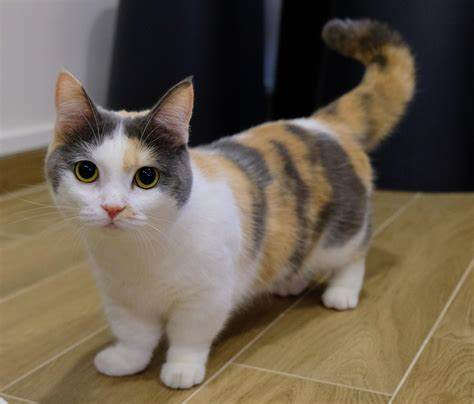

In [76]:
from PIL import Image

image_path='/home/zhang/Downloads/cat.jpg'

catImage=Image.open(image_path)
catImage=catImage.convert('RGB')  # 对png格式的图片，有四个通道
catImage

In [77]:
transform=torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32,32)),
     torchvision.transforms.ToTensor()]
)

catImage=transform(catImage)
catImage.shape

torch.Size([3, 32, 32])

In [78]:
catImage=torch.reshape(catImage,(1,3,32,32))
catImage=catImage.to(device_gpu)
catImage.shape,type(catImage)

(torch.Size([1, 3, 32, 32]), torch.Tensor)

In [79]:
model=torch.load('./model.pth')  # 加载之前训练的模型
model.to(device_gpu)
model.eval()

with torch.no_grad():
    output=model(catImage)
output

tensor([[ 7.0561, -5.5874,  3.7183,  6.1082,  1.8969,  5.2521, -1.7152,  0.3371,
         -5.9415, -8.8585]], device='cuda:0')

In [80]:
output.argmax(1)

tensor([0], device='cuda:0')

In [81]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}